In [14]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional

In [2]:
# 下载 nltk 的所需资源
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kerry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kerry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# 加载数据
df = pd.read_csv('netflix_reviews.csv')

# 查看数据的前几行
print(df.head())

                               reviewId            userName  \
0  5c934dd8-6417-4653-aa21-2d093f468d72      Redwane Stayka   
1  1328c8fe-0596-41c6-9ddf-20a5163a5c50         vivian muir   
2  4ea3b37c-0478-4eb8-9754-7a27f917100c  Madongaolou Edward   
3  7ecc7540-7968-4ba2-be6c-bdf3b0311daf      Stuart Durston   
4  dd57e681-5ae5-4b41-909d-8a868fde751a   Afolayan Damilola   

                                             content  score  thumbsUpCount  \
0  Doesn't allow me to watch with my friend accou...      1              1   
1  i love this app everyone i know uses this app ...      5              0   
2  My phone works fine with other apps but why th...      1              1   
3  Netflix I would have once got a 5 star review....      2              0   
4                                   Good and amazing      5              0   

     reviewCreatedVersion                   at              appVersion  
0  8.114.0 build 19 50680  2024-06-04 21:51:39  8.114.0 build 19 50680  
1   8.

In [4]:
# 检查缺失值
print(df.isnull().sum())

reviewId                    0
userName                    1
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion    16239
at                          0
appVersion              16239
dtype: int64


In [5]:
# 删除 `userName` 和 `content` 缺失值的行
df = df.dropna(subset=['userName', 'content'])
# 删除 `reviewCreatedVersion` 和 `appVersion` 列
df = df.drop(columns=['reviewCreatedVersion', 'appVersion'])
# 文本清理函数
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # 去除HTML标签
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 去除特殊字符，保留字母和空格
    text = text.lower()  # 转为小写
    return text

# 检查是否包含非英文字符的函数
def is_english(text):
    # 检查是否仅包含英文字符和空格
    return re.fullmatch(r'[a-zA-Z\s]*', text) is not None

# 分词和去停用词的函数
def tokenize_and_remove_stopwords(text):
    # 分词
    tokens = word_tokenize(text)
    # 去停用词
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    # 重新组合成字符串
    return filtered_tokens

# 清理 `content` 列中的文本数据
df['cleaned_content'] = df['content'].apply(clean_text)

# 仅保留包含英文字符的评论
df = df[df['cleaned_content'].apply(is_english)]

# 删除 `cleaned_content` 列为空或仅含空格的评论
df = df[df['cleaned_content'].str.strip() != '']

# 应用分词和去停用词
df['tokens'] = df['cleaned_content'].apply(tokenize_and_remove_stopwords)

# 创建情感标签列
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['score'].apply(label_sentiment)

# 将 `score` 列的值减 1，以适应 [0, 4] 的范围
df['score'] = df['score'] - 1

# 将 `at` 列转换为 `datetime` 格式
df['at'] = pd.to_datetime(df['at'])

# 按日期排序数据
df = df.sort_values(by='at')

# 如果需要，将清理后的数据保存到新文件中
df.to_csv('test.csv', index=False)

In [6]:
# 检查清理后的缺失值
print(df.isnull().sum())

reviewId           0
userName           0
content            0
score              0
thumbsUpCount      0
at                 0
cleaned_content    0
tokens             0
sentiment          0
dtype: int64


In [7]:
# 查看清理后的数据前五行
print(df.head())

                                   reviewId       userName  \
21675  e940dd6f-b642-44a6-8b2e-48e69d511a8e  A Google user   
55124  b9ca4a19-91ec-4c81-9240-5dd84408a7d7  A Google user   
33555  a9c91494-6787-4584-95d6-80f7c52e1d9a  A Google user   
17928  32e36441-44c3-465d-9161-8a2d617d685b  A Google user   
53961  7aff0740-fd01-4191-9271-f689820740a5  A Google user   

                                                 content  score  \
21675  There are still some fantastic Netflix origina...      3   
55124  Dont really use the app on my phone as much as...      3   
33555  I love Netflix but on my LG v30+ all HDR looks...      2   
17928  Well I downloaded it recently on my new phone ...      0   
53961  Used to work well, now doesn't recognize my pa...      2   

       thumbsUpCount                  at  \
21675              0 2018-09-12 07:22:12   
55124              0 2018-09-12 07:33:31   
33555              0 2018-09-12 07:38:21   
17928            124 2018-09-12 07:43:26   
5396

In [8]:
# 查看数据的基本信息
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 111986 entries, 21675 to 0
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   reviewId         111986 non-null  object        
 1   userName         111986 non-null  object        
 2   content          111986 non-null  object        
 3   score            111986 non-null  int64         
 4   thumbsUpCount    111986 non-null  int64         
 5   at               111986 non-null  datetime64[ns]
 6   cleaned_content  111986 non-null  object        
 7   tokens           111986 non-null  object        
 8   sentiment        111986 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 8.5+ MB
None


In [9]:
# 查看 `at` 列的日期范围
print("Time Scale:")
print("Earliest Date:", df['at'].min())
print("Latest Date:", df['at'].max())

Time Scale:
Earliest Date: 2018-09-12 07:22:12
Latest Date: 2024-06-04 21:51:39


In [10]:
# 按月统计数据量
monthly_counts = df['at'].dt.to_period('M').value_counts().sort_index()
print("\nVolume of statistics by month:")
print(monthly_counts)

# 按年统计数据量（如果数据跨越多个年份）
yearly_counts = df['at'].dt.to_period('Y').value_counts().sort_index()
print("\nVolume of statistics by year:")
print(yearly_counts)


Volume of statistics by month:
at
2018-09     702
2018-10    1569
2018-11    1376
2018-12    1155
2019-01    1188
           ... 
2024-02    2927
2024-03    3231
2024-04    2743
2024-05    4616
2024-06     627
Freq: M, Name: count, Length: 70, dtype: int64

Volume of statistics by year:
at
2018     4802
2019    16879
2020    28569
2021    17736
2022    15122
2023    12850
2024    16028
Freq: A-DEC, Name: count, dtype: int64


In [11]:
# 选择拆分日期（例如 2024-01-01）
split_date = '2024-01-01' 

# 拆分数据集
train_df = df[df['at'] < split_date]
test_df = df[df['at'] >= split_date]

# 查看拆分后的数据集大小
print("\nTraining set size:", train_df.shape)
print("Test Set Size:", test_df.shape)

# 查看拆分点前后的数据量
print("\nVolume of data before split point:", train_df['at'].max())
print("Volume of data after split point:", test_df['at'].min())


Training set size: (95958, 9)
Test Set Size: (16028, 9)

Volume of data before split point: 2023-12-31 20:55:51
Volume of data after split point: 2024-01-01 00:15:11


In [19]:
# LogisticRegression
# # 特征提取
# vectorizer = TfidfVectorizer()
# X_train_tfidf = vectorizer.fit_transform(train_df['content'])
# X_test_tfidf = vectorizer.transform(test_df['content'])

# # 训练情绪分析模型
# # model = LogisticRegression()
# model = LogisticRegression(max_iter=200)  # 增加迭代次数

# model.fit(X_train_tfidf, train_df['score'])

# # 预测和评估
# y_pred = model.predict(X_test_tfidf)
# print("情绪分析模型报告:")
# print(classification_report(test_df['score'], y_pred))

情绪分析模型报告:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      8602
           1       0.31      0.03      0.05      1360
           2       0.26      0.11      0.16      1126
           3       0.30      0.17      0.22      1053
           4       0.72      0.84      0.77      3887

    accuracy                           0.72     16028
   macro avg       0.47      0.42      0.41     16028
weighted avg       0.65      0.72      0.67     16028



D:\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# from sklearn.naive_bayes import MultinomialNB

# # 训练模型
# model = MultinomialNB()
# model.fit(X_train_tfidf, train_df['score'])

# # 预测和评估
# y_pred = model.predict(X_test_tfidf)
# print("朴素贝叶斯模型报告:")
# print(classification_report(test_df['score'], y_pred))

In [ ]:
# from sklearn.svm import SVC

# # 训练模型
# model = SVC(kernel='linear')
# model.fit(X_train_tfidf, train_df['score'])

# # 预测和评估
# y_pred = model.predict(X_test_tfidf)
# print("SVM模型报告:")
# print(classification_report(test_df['score'], y_pred))

Epoch 1/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 295s 108ms/step - accuracy: 0.7402 - loss: 0.6724 - val_accuracy: 0.8171 - val_loss: 0.5295
Epoch 2/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 298s 110ms/step - accuracy: 0.8081 - loss: 0.5044 - val_accuracy: 0.8184 - val_loss: 0.5143
Epoch 3/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 289s 107ms/step - accuracy: 0.8263 - loss: 0.4545 - val_accuracy: 0.8125 - val_loss: 0.5299
Epoch 4/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 294s 109ms/step - accuracy: 0.8446 - loss: 0.4081 - val_accuracy: 0.8083 - val_loss: 0.5574
Epoch 5/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 293s 109ms/step - accuracy: 0.8686 - loss: 0.3483 - val_accuracy: 0.7905 - val_loss: 0.6321
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step
Overall Accuracy:  79.35%
LSTM模型报告:
              precision    recall  f1-score   support

    Negative       0.88      0.85      0.87      9962
     Neutral       0.19      0.15      0.16      1126
    Positive       0.74      0.82      0.78      4940

    accuracy                          

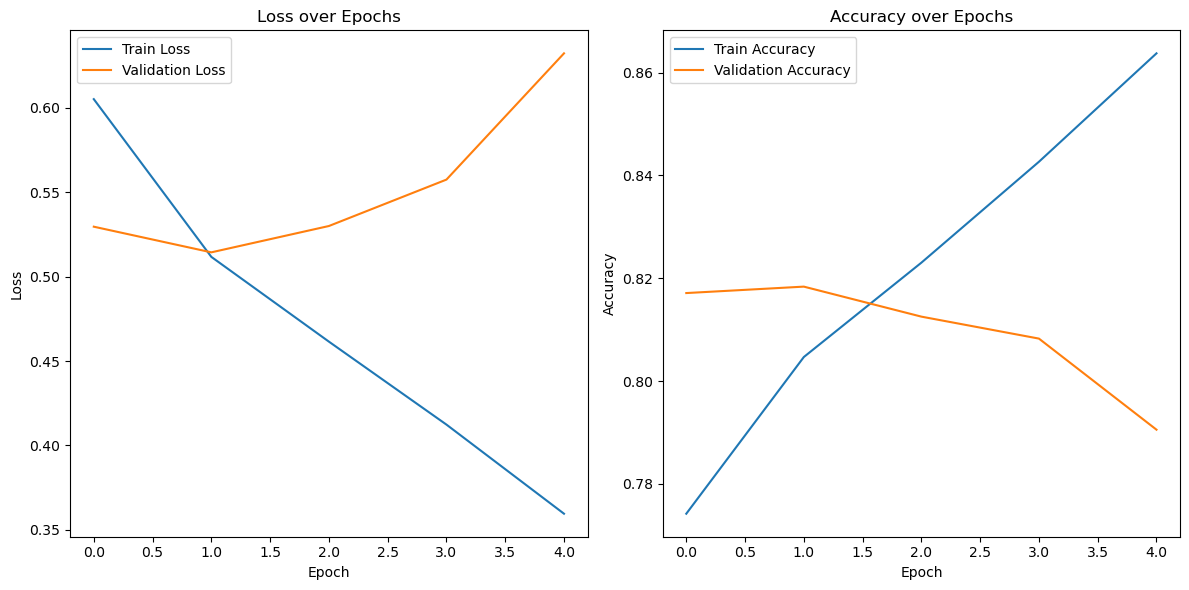

In [16]:
# LSTM 
# 准备 LSTM 模型的输入数据
X_train = train_df['cleaned_content']
X_test = test_df['cleaned_content']

# 转换情感标签为数值编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sentiment'])
y_test = label_encoder.transform(test_df['sentiment'])

# 创建 Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

# 将文本转换为序列
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 填充序列
max_len = 100  # 选择合适的序列长度
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# 创建 LSTM 模型
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# 评估模型
y_pred_prob = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_prob, axis=-1)

# 打印模型评估报告
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test, y_pred_classes) * 100))
print("LSTM模型报告:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# 绘制训练过程中的准确率和损失
plt.figure(figsize=(12, 6))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 绘制准确率
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 387s 142ms/step - accuracy: 0.7146 - loss: 0.7215 - val_accuracy: 0.8201 - val_loss: 0.5509
Epoch 2/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 371s 137ms/step - accuracy: 0.8014 - loss: 0.5449 - val_accuracy: 0.8248 - val_loss: 0.5216
Epoch 3/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 373s 138ms/step - accuracy: 0.8108 - loss: 0.5075 - val_accuracy: 0.8266 - val_loss: 0.5235
Epoch 4/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 373s 138ms/step - accuracy: 0.8173 - loss: 0.4752 - val_accuracy: 0.8200 - val_loss: 0.5372
Epoch 5/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 373s 138ms/step - accuracy: 0.8247 - loss: 0.4480 - val_accuracy: 0.8108 - val_loss: 0.5729
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step
Overall Accuracy:  81.11%
LSTM模型报告:
              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      9962
     Neutral       0.26      0.03      0.06      1126
    Positive       0.73      0.84      0.78      4940

    accuracy                          

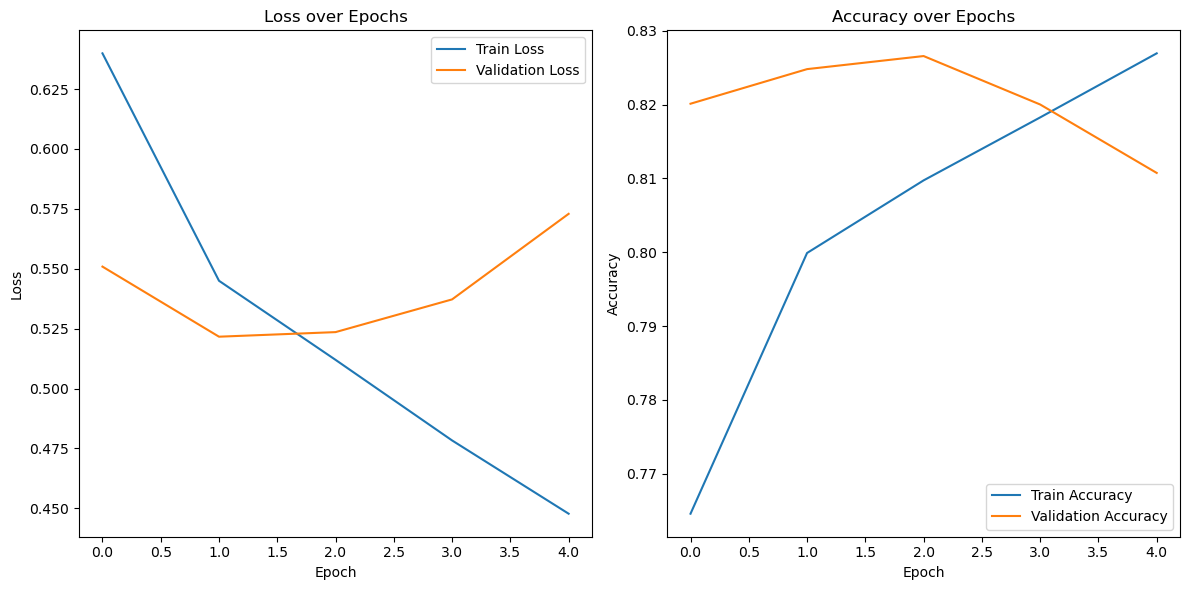

In [17]:
# 加入Dropout
# 创建 LSTM 模型
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 个情感等级

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# 评估模型
y_pred_prob = model.predict(X_test_pad)
y_pred_classes = y_pred_prob.argmax(axis=-1)

# 打印模型评估报告
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test, y_pred_classes) * 100))
print("LSTM模型报告:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# 绘制训练过程中的准确率和损失
plt.figure(figsize=(12, 6))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 绘制准确率
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/5


D:\Anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2699/2699 ━━━━━━━━━━━━━━━━━━━━ 405s 148ms/step - accuracy: 0.6123 - loss: 0.9213 - val_accuracy: 0.7940 - val_loss: 0.5973
Epoch 2/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 399s 148ms/step - accuracy: 0.7928 - loss: 0.5750 - val_accuracy: 0.8074 - val_loss: 0.5281
Epoch 3/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 385s 143ms/step - accuracy: 0.8034 - loss: 0.5351 - val_accuracy: 0.8044 - val_loss: 0.5608
Epoch 4/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 384s 142ms/step - accuracy: 0.8109 - loss: 0.5105 - val_accuracy: 0.8219 - val_loss: 0.5194
Epoch 5/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 385s 143ms/step - accuracy: 0.8193 - loss: 0.4807 - val_accuracy: 0.8098 - val_loss: 0.5601
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step
Overall Accuracy:  81.18%
LSTM模型报告:
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87      9962
     Neutral       0.00      0.00      0.00      1126
    Positive       0.73      0.84      0.78      4940

    accuracy                           0.81     

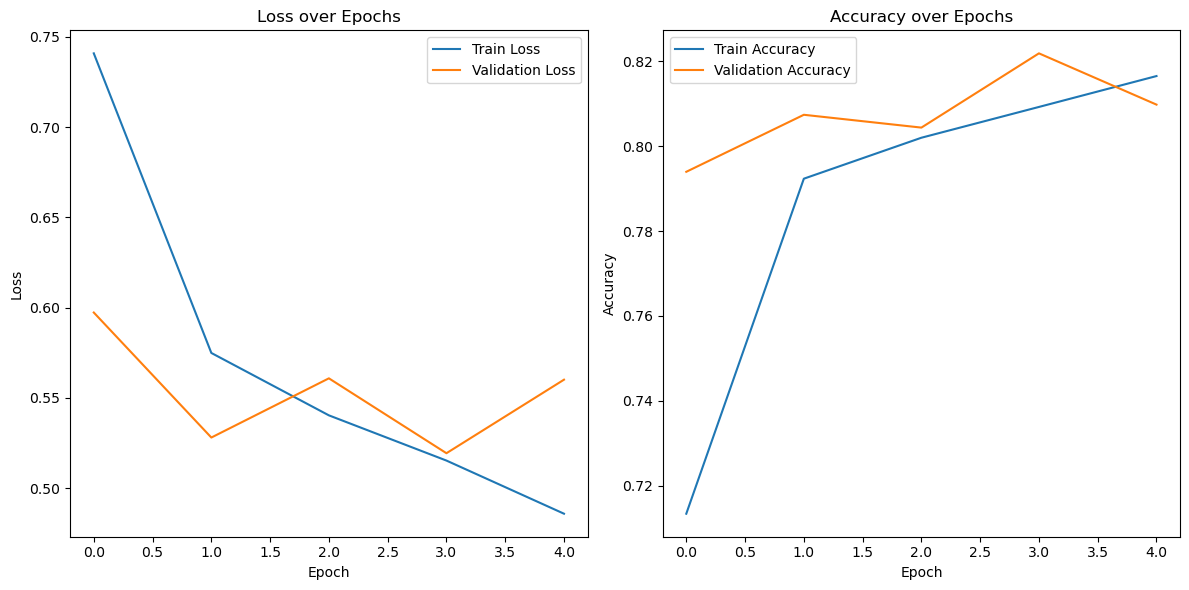

In [18]:
# 加入更多正则化方法和调整超参数
# 填充序列
max_len = 100  # 选择合适的序列长度
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# 创建 LSTM 模型
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax')) 

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# 评估模型
y_pred_prob = model.predict(X_test_pad)
y_pred_classes = y_pred_prob.argmax(axis=-1)

# 打印模型评估报告
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test, y_pred_classes) * 100))
print("LSTM模型报告:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# 绘制训练过程中的准确率和损失
plt.figure(figsize=(12, 6))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 绘制准确率
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 507s 186ms/step - accuracy: 0.6903 - loss: 1.0630 - val_accuracy: 0.7487 - val_loss: 0.6801 - learning_rate: 0.0010
Epoch 2/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 493s 183ms/step - accuracy: 0.7570 - loss: 0.8519 - val_accuracy: 0.7479 - val_loss: 0.6334 - learning_rate: 0.0010
Epoch 3/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 495s 183ms/step - accuracy: 0.7750 - loss: 0.7881 - val_accuracy: 0.7848 - val_loss: 0.5714 - learning_rate: 0.0010
Epoch 4/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 518s 192ms/step - accuracy: 0.7921 - loss: 0.7232 - val_accuracy: 0.7420 - val_loss: 0.6443 - learning_rate: 0.0010
Epoch 5/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8092 - loss: 0.6594
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 501s 186ms/step - accuracy: 0.8092 - loss: 0.6594 - val_accuracy: 0.7396 - val_loss: 0.6655 - learning_rate: 0.0010
Epoch 6/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 500s 185ms/st

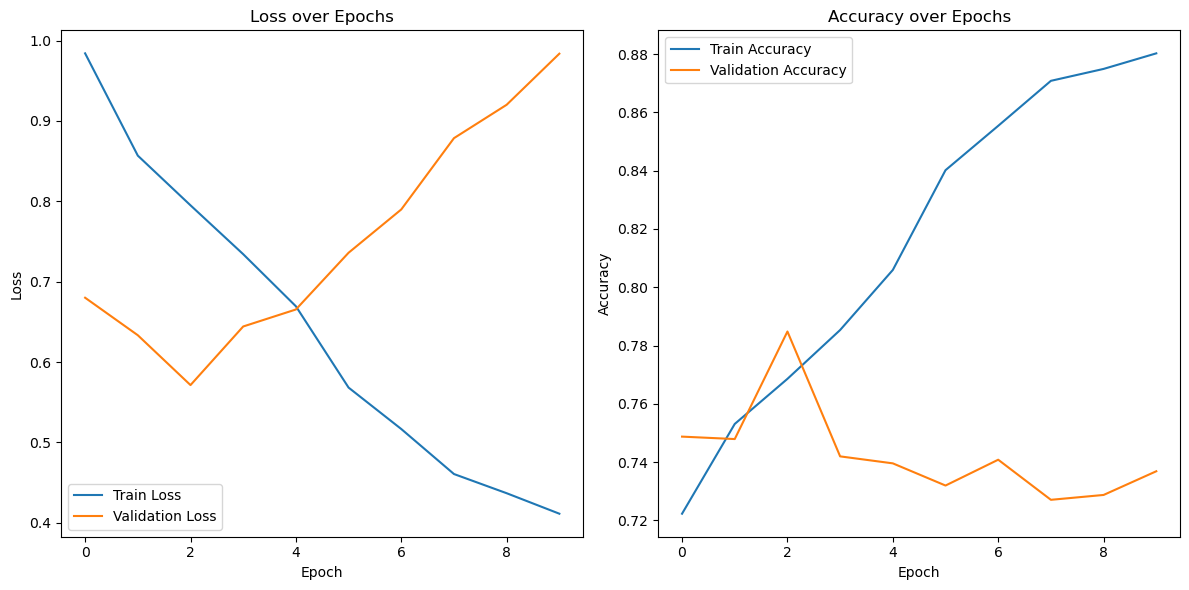

In [19]:
# 设置不同类别权重

# 创建 LSTM 模型
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
# 设置类别权重
class_weights = {
    0: 1.0,   # Negative
    1: 3.0,   # Neutral
    2: 1.0,   # Positive
}

# 学习率调度
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    X_train_pad, y_train,
    epochs=10, 
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[lr_scheduler],
    verbose=1
)

# 评估模型
y_pred_prob = model.predict(X_test_pad)
y_pred_classes = y_pred_prob.argmax(axis=-1)

# 打印模型评估报告
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test, y_pred_classes) * 100))
print("LSTM模型报告:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# 绘制训练过程中的准确率和损失
plt.figure(figsize=(12, 6))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 绘制准确率
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()